# Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.optimize as opt
from sklearn.preprocessing import MinMaxScaler

import matplotlib
import matplotlib.font_manager
import matplotlib.pyplot as plt

# matplotlib plotting style
%matplotlib inline
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Hack'

# seaborn plotting style
sns.set()
sns.set_style('whitegrid')

# Setup

In [2]:
# reusable data dir
datadir = '../data/'

# Geo Data

In [3]:
# read fips county data
fips_datafile = datadir + 'csv/fips.csv'
fips_df = pd.read_csv(fips_datafile, encoding="ISO-8859-1")

# cleanup dataframe
fips_df['county_name'] = fips_df['county_name'].str.lower()
fips_df['state_abbr'] = fips_df['state_abbr'].str.lower()
fips_df['county_name'] = fips_df['county_name'].str.replace(' county', '')

# filter to Tennessee only
fips_df[fips_df['state_abbr'] == 'tn'].head()

,fips,county_name,state_abbr,state_name,long_name,sumlev,region,division,state,county,crosswalk,region_name,division_name
2431,47001,anderson,tn,Tennessee,Anderson County TN,50.0,3.0,6.0,47.0,1.0,3-6-47-1,South,East South Central
2432,47003,bedford,tn,Tennessee,Bedford County TN,50.0,3.0,6.0,47.0,3.0,3-6-47-3,South,East South Central
2433,47005,benton,tn,Tennessee,Benton County TN,50.0,3.0,6.0,47.0,5.0,3-6-47-5,South,East South Central
2434,47007,bledsoe,tn,Tennessee,Bledsoe County TN,50.0,3.0,6.0,47.0,7.0,3-6-47-7,South,East South Central
2435,47009,blount,tn,Tennessee,Blount County TN,50.0,3.0,6.0,47.0,9.0,3-6-47-9,South,East South Central


In [4]:
# read hand-defined "metro area"
metro_datafile = datadir + 'json/metro.json'

# use the 60min catchment area
drive_time = '60'
with open(metro_datafile) as f:
    metro_data = json.load(f)

# assign metro to fips
knx_metro_fips = []
for county in metro_data[drive_time]:
    knx_metro_fips.append(
        fips_df[(fips_df['county_name'] == county)
                & (fips_df['state_abbr'] == 'tn')]['fips'].values[0])
print('Knoxville Metro FIPS: {}'.format(knx_metro_fips))

Knoxville Metro FIPS: [47001, 47009, 47013, 47025, 47029, 47035, 47057, 47059, 47063, 47089, 47093, 47105, 47107, 47121, 47123, 47129, 47143, 47145, 47151, 47155, 47173]


# COVID Data

In [5]:
# read NY Times covid data set
ny_times_datafile = datadir + 'ny-times/us-counties.csv'
ny_times_df = pd.read_csv(ny_times_datafile)


In [6]:
# remove NA's
ny_times_df.fillna(0, inplace=True)

# convert to py datetime
ny_times_df['date'] = pd.to_datetime(ny_times_df['date'], errors='coerce')

# conert fips from string to int
ny_times_df['fips'] = ny_times_df['fips'].astype('int')

# filter for data in KNX metro fips
knx_df = ny_times_df[ny_times_df['fips'].isin(knx_metro_fips)]
knx_df.head()

,date,county,state,fips,cases,deaths
1570,2020-03-12,Knox,Tennessee,47093,1,0
1872,2020-03-13,Jefferson,Tennessee,47089,1,0
1873,2020-03-13,Knox,Tennessee,47093,1,0
2234,2020-03-14,Campbell,Tennessee,47013,1,0
2237,2020-03-14,Jefferson,Tennessee,47089,1,0


# County Time Series

## Individual Counties

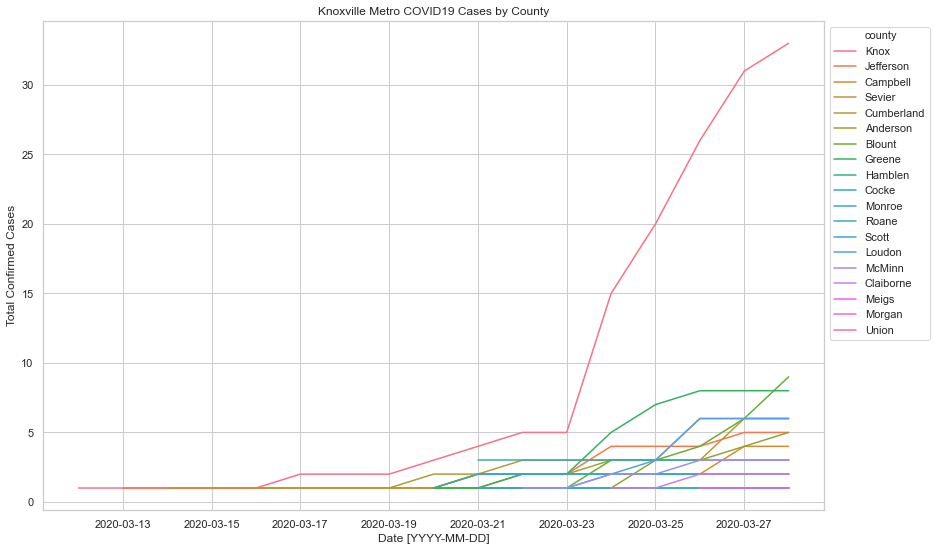

In [7]:
# plot cases per county per day
plt.figure(figsize=(14, 9))
ax = sns.lineplot(x='date', y='cases', hue='county', markers=True, dashes=False, data=knx_df)
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.xlabel('Date [YYYY-MM-DD]')
plt.ylabel('Total Confirmed Cases')
plt.title('Knoxville Metro COVID19 Cases by County')
plt.savefig('metro-county-cases.png')

## All Counties

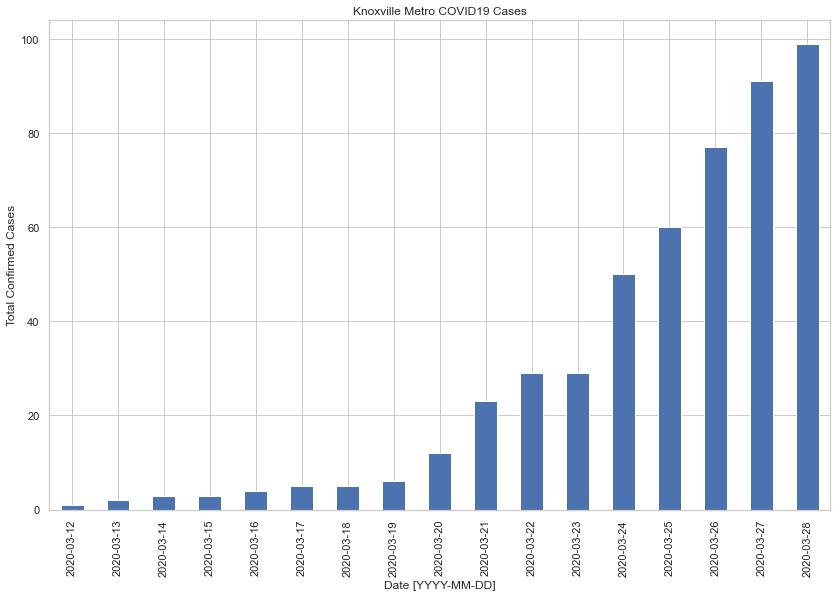

In [8]:
# plot aggregate cases per day for KNX metro
plt.figure(figsize=(14, 9))
case_series = knx_df.groupby(knx_df.date.dt.date)['cases'].sum()
case_series.plot(kind='bar')
plt.xlabel('Date [YYYY-MM-DD]')
plt.ylabel('Total Confirmed Cases')
plt.title('Knoxville Metro COVID19 Cases')
plt.savefig('metro-all.png')

In [9]:
# define a logistic function
def logifunc(x, A, x0, k):
    return A / (1. + np.exp(-k * (x - x0)))

# select dates and cases as arrays
x = [n for n, _ in enumerate(case_series.index)]
y = case_series.values

# scale case number for fitting
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1))
y_scaled = y_scaled.reshape(1, -1)[0]

In [10]:
# use scipy opt to fit logistic
popt, pcov = opt.curve_fit(logifunc, x, y_scaled, maxfev=100000)
x_fit = np.linspace(0, 30, num=200)
y_fit = logifunc(x_fit, *popt)

# reverse the scaling
y_fit = y_fit.reshape(-1, 1)
y_fit = scaler.inverse_transform(y_fit).reshape(1, -1)[0]

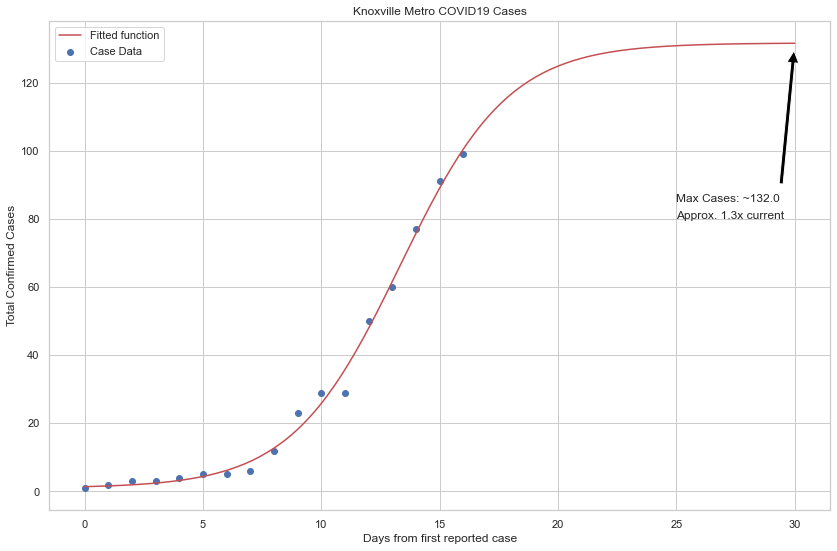

In [11]:
# plot projected cases
fig, ax = plt.subplots(figsize=(14, 9))
plt.scatter(x, y, label='Case Data')
plt.plot(x_fit, y_fit, 'r-', label='Fitted function')
plt.legend()
plt.xlabel('Days from first reported case')
plt.ylabel('Total Confirmed Cases')
plt.title('Knoxville Metro COVID19 Cases')
ax.annotate('Max Cases: ~{}'.format(round(max(y_fit))),
            xy=(x_fit[-1], y_fit[-1]),
            xycoords='data',
            xytext=(25, 85),
            arrowprops=dict(facecolor='black', shrink=0.05))
ratio = max(y_fit) / max(y)
ax.text(25, 80, "Approx. {}x current".format(round(ratio, 1)))
plt.savefig('metro-all-fit.png')